In [2]:
from pathlib import Path
import webbrowser

import matplotlib.pyplot as plt
import pandas as pd
from presp.prescriptor import NNPrescriptorFactory
import torch
from tqdm import tqdm
import yaml

from esp.evaluator import EnROADSEvaluator
from esp.prescriptor import EnROADSPrescriptor
from enroadspy.generate_url import actions_to_url

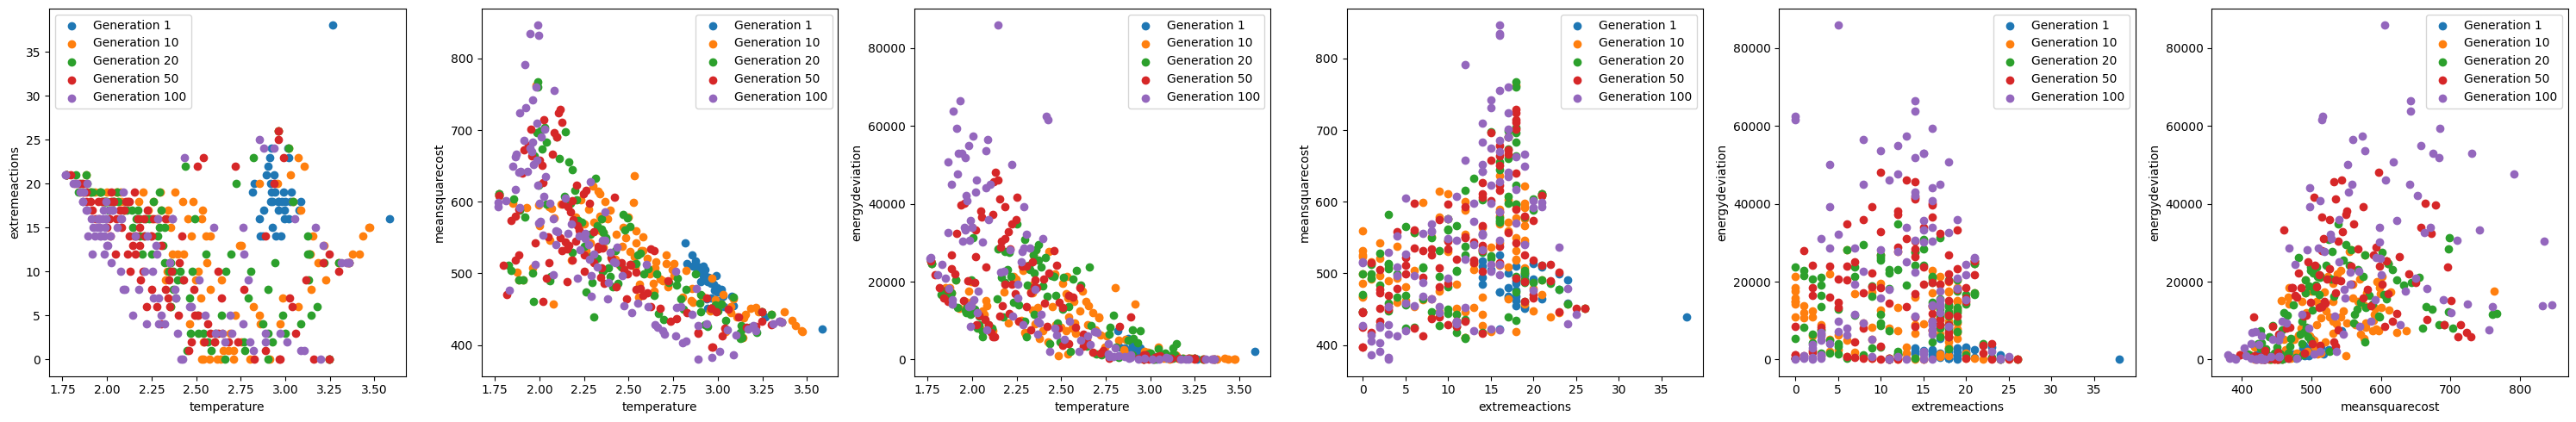

In [3]:
results_dir = Path("esp/results/three")
with open(results_dir / "config.yml") as f:
    config = yaml.safe_load(f)
outcomes = config["eval_params"]["outcomes"]

import math
ncr = int(math.factorial(len(outcomes)) / (2 * math.factorial(len(outcomes) - 2)))
fig, axes = plt.subplots(1, ncr, figsize=(ncr * 5, 5), tight_layout=True)
axes = axes.flatten()
ax_idx = 0
for i in range(len(outcomes)-1):
    for j in range(i+1, len(outcomes)):
        gens = [1, 10, 20, 50, 100]
        for gen in gens:
            df = pd.read_csv(results_dir / f"{gen}.csv")
            df = df[df["rank"] == 1]
            axes[ax_idx].scatter(df[outcomes[i]], df[outcomes[j]], label=f"Generation {gen}")
        axes[ax_idx].set_xlabel(outcomes[i])
        axes[ax_idx].set_ylabel(outcomes[j])
        axes[ax_idx].legend()
        ax_idx += 1

plt.show()

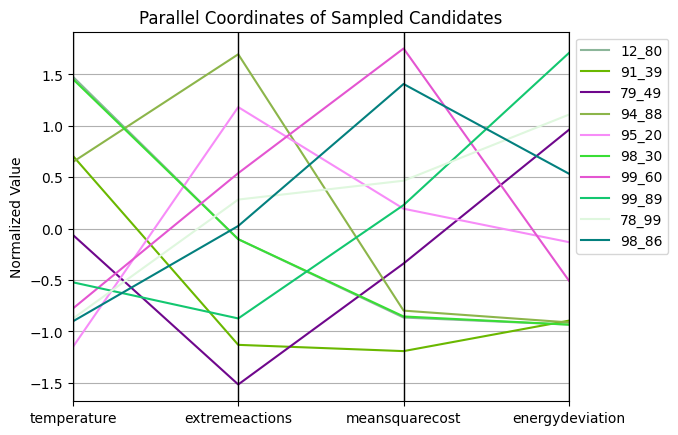

In [4]:
def plot_parallel_coordinates():
    df = pd.read_csv(results_dir / "100.csv")
    pareto = df[df["rank"] == 1].iloc[:10]

    pareto[outcomes] = (pareto[outcomes] - pareto[outcomes].mean()) / pareto[outcomes].std()
    
    fig, ax = plt.subplots()
    pd.plotting.parallel_coordinates(pareto[["cand_id"] + outcomes], "cand_id", ax=ax)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel("Normalized Value")
    ax.set_title("Parallel Coordinates of Sampled Candidates")
    plt.show()

plot_parallel_coordinates()

In [5]:
evaluator = EnROADSEvaluator(**config["eval_params"])
factory = NNPrescriptorFactory(EnROADSPrescriptor, **config["prescriptor_params"])

make: `enroads' is up to date.
make: `enroads' is up to date.


In [6]:
def eval_candidate(cand_id: str):
    candidate = factory.load(results_dir / cand_id.split("_")[0] / f"{cand_id}")
    context_actions_dicts = evaluator.context_to_actions(candidate, evaluator.dataset)
    outcomes_dfs = evaluator.context_actions_to_outcomes(context_actions_dicts)
    metrics = evaluator.cao_to_metrics(context_actions_dicts, outcomes_dfs)
    
    return context_actions_dicts, outcomes_dfs, metrics

In [7]:
baseline_context_actions = [d[0] for d in evaluator.dataset.context_dicts]
baseline_outcomes = evaluator.context_actions_to_outcomes(baseline_context_actions)
baseline_metrics = evaluator.cao_to_metrics(baseline_context_actions, baseline_outcomes)

In [8]:
df = pd.read_csv(results_dir / "100.csv")
df = df[df["rank"] == 1].iloc[:10]

all_context_actions, all_outcomes, all_metrics = [], [], []
for cand_id in tqdm(df["cand_id"]):
    ca, o, m = eval_candidate(cand_id)
    all_context_actions.append(ca)
    all_outcomes.append(o)
    all_metrics.append(m)

100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_40882/3964474041.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


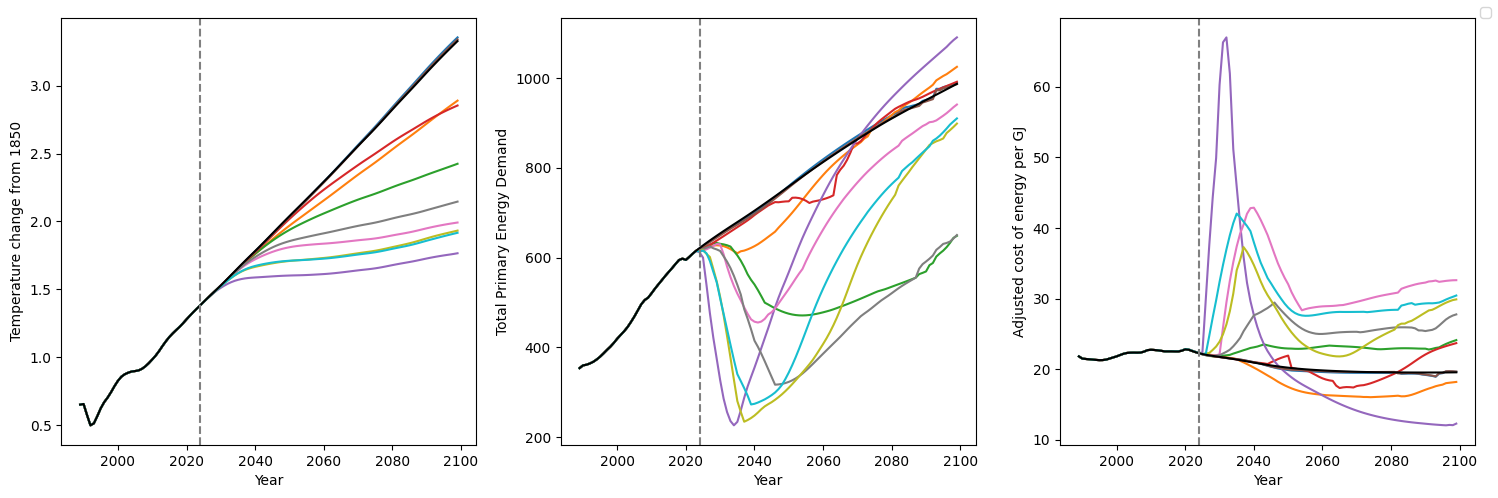

In [ ]:
def plot_outcome(outcomes_list: list[pd.DataFrame], outcomes: list[str], context_idx: int):
    fig, axes = plt.subplots(1, len(outcomes), figsize=(len(outcomes) * 5, 5), tight_layout=True)
    axes = axes.flatten()
    for ax, outcome in zip(axes, outcomes):
        for i, outcomes_dfs in enumerate(outcomes_list):
            outcomes_df = outcomes_dfs[context_idx]
            baseline_params = {"color": "black"} if i == len(outcomes_list) - 1 else {}
            ax.plot(list(range(2100 - len(outcomes_df), 2100)), outcomes_df[outcome], **baseline_params)
        ax.axvline(2024, linestyle="--", color="gray")
        ax.set_xlabel("Year")
        ax.set_ylabel(outcome)

    plt.show()

plot_outcome(all_outcomes + [baseline_outcomes], ["Temperature change from 1850", "Total Primary Energy Demand", "Adjusted cost of energy per GJ"], 0)

In [ ]:
df = pd.read_csv(results_dir / "100.csv")
df = df[df["rank"] == 1]

df = df.sort_values(by="extremeactions")

for idx, row in df.iterrows():
    cand_id = row["cand_id"]
    print(row["temperature"], row["extremeactions"])
    presc = factory.load(results_dir / cand_id.split("_")[0] / cand_id)
    actions_tensor = presc.forward(torch.ones((1, 1)).to("mps"))
    actions_dict = evaluator.output_parser.parse_actions_dicts(actions_tensor)
    url = actions_to_url(actions_dict[0])
    webbrowser.open(url)

2.21314 0.0
1.99904 1.0
1.95302 2.0
1.91111 3.0
1.88075 4.0
1.877 5.0
1.82195 6.0
1.82043 7.0
1.81731 9.0
1.79835 16.0
1.78799 17.0
1.75573 18.0
1.74819 19.0
1.74629 20.0
1.74342 21.0
